# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 19/02/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os
import concurrent.futures
import timeit

import matplotlib
%matplotlib widget

import h5py
from tqdm.notebook import tqdm
import numba
import pprint
import numpy as np
import skimage.transform
import ipywidgets as ipyw
import matplotlib.pyplot as plt

import utils

import ImageD11.refinegrains
import ImageD11.columnfile
import ImageD11.sinograms.properties
import ImageD11.sinograms.roi_iradon
from ImageD11.blobcorrector import eiger_spatial
from ImageD11.grain import grain

In [3]:
# OLD DATASETS

# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA
# In this case, use this cell to specify where your experimental folder is, and do not run the cell below
# e.g /data/visitor/4752/id11/20210513

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ma4752/id11/20210618"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ma4752/id11/20240118/James"

total 5249
-rwxr-x---  1 backup backup 5372439 Jun 25  2021 ma4752_id11.h5
drwxr-x--- 25 backup backup    4096 Jan 18 06:08 MA4752_S4_2_XRD


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "MA4752_S4_2_XRD"
dataset = "DTL1z90"

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

par_path = 'nickel.par'

e2dx_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf"
e2dy_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"

In [6]:
# Load the dataset (for motor positions, not sure why these are not in peaks)
ds = ImageD11.sinograms.dataset.load(dset_path)

In [7]:
# Import 4D peaks

cf_4d = ImageD11.columnfile.columnfile(ds.col4dfile)

cf_4d.parameters.loadparameters(par_path)
cf_4d.updateGeometry()

print(f"Read {cf_4d.nrows} 4D peaks")

Reading your columnfile in hdf format
Read 11722880 4D peaks


In [8]:
def read_grains(ds):
    ds.grainsfile_carbides = os.path.join(ds.analysispath, ds.dsname + '_grains_carbides.h5')
    with h5py.File(ds.grainsfile_carbides, 'r') as hin:      
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            g = ImageD11.grain.grain(ubi)
            g.gid = int(gid_string)
            g.peaks_4d = gg['peaks_4d_indexing'][:]
            grains.append(g)
    
    return grains

In [9]:
grains = read_grains(ds)

for grain in grains:
    # print(grain.gid)
    grain.a = np.cbrt(np.linalg.det(grain.ubi))
    
print(f"{len(grains)} grains imported")

  0%|          | 0/1025 [00:00<?, ?it/s]

1025 grains imported


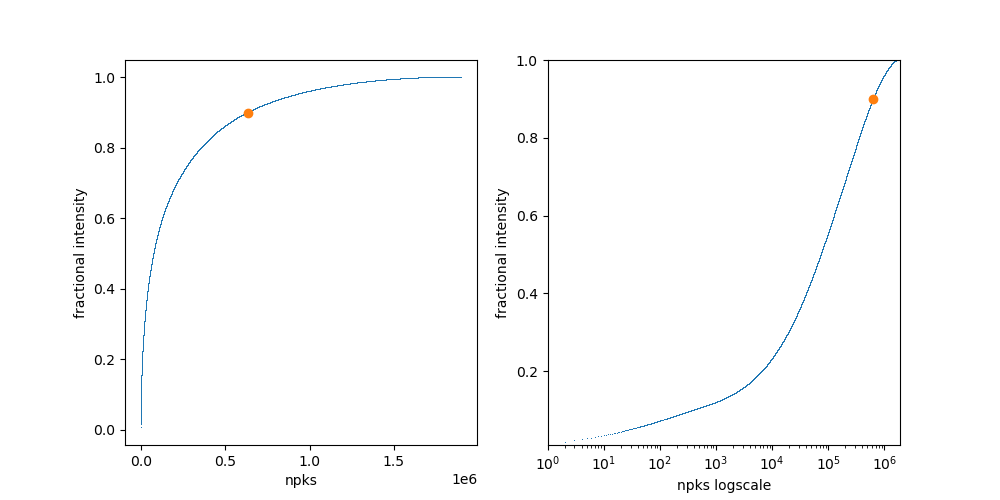

635491


In [10]:
# isolate Nickel peaks, and remove them from the dataset
ni_peaks_mask = utils.unitcell_peaks_mask(cf_4d, dstol=0.0075, dsmax=cf_4d.ds.max())

carbides = cf_4d.copy()
carbides.filter(~ni_peaks_mask)

# Update geometry for carbides peaks

par_path = 'carbide.par'
carbides.parameters.loadparameters(par_path)
carbides.updateGeometry()

cf_strong = utils.selectpeaks(carbides, dstol=0.0075, dsmax=carbides.ds.max(), frac=0.9, doplot=0.01)
print(cf_strong.nrows)

In [11]:
# If the sinograms are only half-sinograms (we scanned dty across half the sample rather than the full sample), set the below to true:
is_half_scan = True

In [12]:
if is_half_scan:
    c0 = 0
    # check / fix the centre of rotation
    # get value of bin closest to c0
    central_bin = np.argmin( abs(ds.ybincens - c0))
    # get centre dty value of this vin
    central_value = ds.ybincens[central_bin]

    lo_side = ds.ybincens[:central_bin+1]
    hi_side = ds.ybincens[central_bin:]
    
    # get the hi/lo side which is widest
    # i.e if you go from -130 to +20, it selects -130
    yrange = max( hi_side[-1] - hi_side[0], lo_side[-1] - lo_side[0] )

    # round to nearest multiple of ds.ystep
    yrange = np.ceil( yrange / ds.ystep ) * ds.ystep
    
    # make new ymin and ymax that are symmetric around central_value
    ds.ymin = central_value - yrange
    ds.ymax = central_value + yrange
    
    new_yrange = ds.ymax - ds.ymin
    
    # determine new number of y bins
    ny = int(new_yrange//ds.ystep) + 1
    
    ds.ybincens = np.linspace(ds.ymin, ds.ymax, ny)
    ds.ybinedges = np.linspace(ds.ymin - ds.ystep / 2, ds.ymax + ds.ystep / 2, ny + 1)
    
    print(len(ds.ybincens))
    print(ds.ybincens)
    print(ds.ystep)
    print(yrange)
    print(ny)

1040
[-129.9998688  -129.7496286  -129.49938839 ...  129.49922247  129.74946268
  129.99970288]
0.2499995881556602
129.9997858409433
1040


In [13]:
# load mask for whole sample from Ni grain reconstruction

def read_ni_grains(ds):
    with h5py.File(ds.grainsfile, 'r') as hin:      
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            g = ImageD11.grain.grain(ubi)
            g.gid = int(gid_string)
            g.sample_mask = gg['circle_mask'][:]
            # g.etasigns_4d = gg['etasigns_4d'][:]
            # g.hkl_4d = gg['hkl_4d'][:]
            # g.mask_4d = gg['mask_4d'][:]
            # g.mask_4d_greedy = gg['mask_4d_greedy'][:]
            # g.peak_indices_4d = gg['peak_indices_4d'][:]
            # g.npks_4d = gg.attrs['npks_4d']
            # g.npks_4d_greedy = gg.attrs['npks_4d_greedy']
            grains.append(g)
    
    return grains

ni_grains = read_ni_grains(ds)
whole_sample_mask = ni_grains[0].sample_mask

  0%|          | 0/45 [00:00<?, ?it/s]

In [14]:
tol = 0.25

# column to store the grain labels
labels_4d_strong = np.zeros(cf_strong.nrows, 'i')
# get all g-vectors from columnfile
gvecs_4d_strong = np.transpose((cf_strong.gx,cf_strong.gy,cf_strong.gz)).astype(float)
# column to store drlv2 (error in hkl)
drlv2 = np.ones(cf_strong.nrows, 'd')
# iterate over all grains
print(f"Scoring and assigning {len(grains)} grains")
for g in tqdm(grains):
    n = ImageD11.cImageD11.score_and_assign(g.ubi, gvecs_4d_strong, tol, drlv2, labels_4d_strong, g.gid)

# add the labels column to the columnfile
cf_strong.addcolumn(labels_4d_strong, 'grain_id')

print("Storing peak data in grains")
# iterate through all the grains
for g in tqdm(grains):
    # store this grain's peak indices so we know which 4D peaks we used for sinograms
    g.mask_4d = cf_strong.grain_id == g.gid
    g.peaks_4d = cf_strong.index[g.mask_4d]

Scoring and assigning 1025 grains


  0%|          | 0/1025 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/1025 [00:00<?, ?it/s]

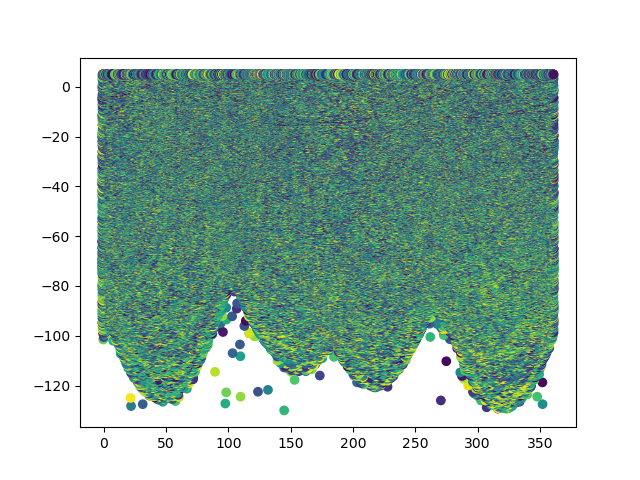

In [15]:
fig, ax = plt.subplots()
m = cf_strong.grain_id >= 0
ax.scatter(cf_strong.omega[m], cf_strong.dty[m], c=cf_strong.grain_id[m])
plt.show()

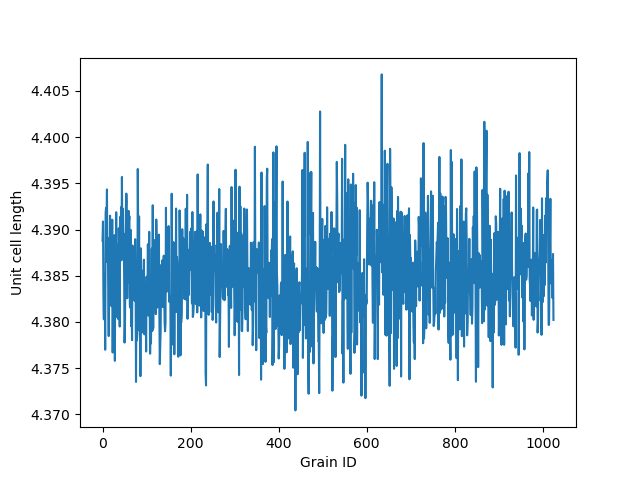

4.385144415380127


In [16]:
mean_unit_cell_lengths = [grain.a for grain in grains]

fig, ax = plt.subplots()
ax.plot(mean_unit_cell_lengths)
ax.set_xlabel("Grain ID")
ax.set_ylabel("Unit cell length")
plt.show()

a0 = np.median(mean_unit_cell_lengths)
    
print(a0)

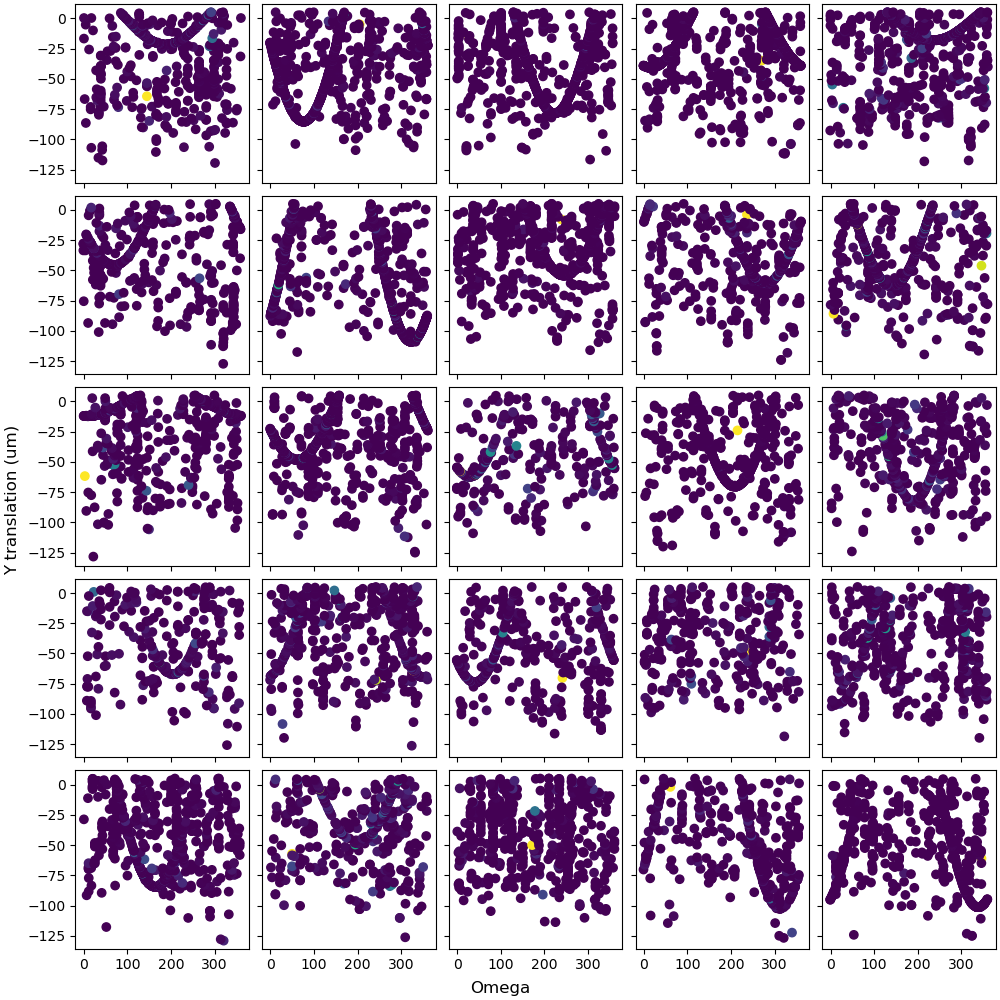

In [17]:
n_grains_to_plot=25

grains_step = len(grains)//n_grains_to_plot + 1

grid_size = np.ceil(np.sqrt(len(grains[::grains_step]))).astype(int)
nrows = (len(grains[::grains_step])+grid_size-1)//grid_size

# plt.style.use('light_background')
fig, axs = plt.subplots(grid_size, nrows, figsize=(10,10), layout="constrained", sharex=True, sharey=True)
for i, ax in enumerate(axs.ravel()):
    if i < len(grains[::grains_step]):
    # get corresponding grain for this axis
        g = grains[::grains_step][i]
        m = cf_strong.grain_id == g.gid
        ax.scatter(cf_strong.omega[m], cf_strong.dty[m], c=cf_strong.sum_intensity[m])
        
fig.supxlabel("Omega")
fig.supylabel("Y translation (um)")
    
plt.show()

In [18]:
for grain in tqdm(grains):
    grain.peaks_4d_selected, grain.cen, grain.dx, grain.dy = utils.graincen(grain.gid, cf_strong, doplot=False)
    grain.rgb_z = utils.grain_to_rgb(grain, ax=(0,0,1),)# symmetry = Symmetry.cubic)
    grain.rgb_y = utils.grain_to_rgb(grain, ax=(0,1,0),)# symmetry = Symmetry.cubic)
    grain.rgb_x = utils.grain_to_rgb(grain, ax=(1,0,0),)# symmetry = Symmetry.cubic)

  0%|          | 0/1025 [00:00<?, ?it/s]

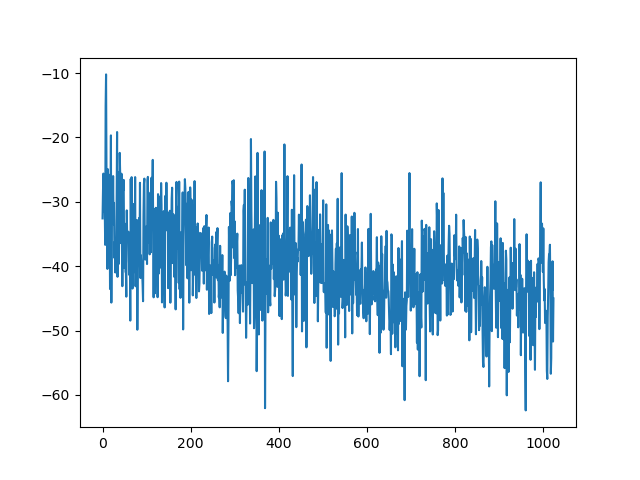

In [19]:
# make sure we get cen right (centre of rotation should be the middle of dty)
fig, ax = plt.subplots()
ax.plot([g.cen for g in grains])

plt.show()

In [20]:
c0 = np.median([g.cen for g in grains])

print('Center of rotation in dty', c0)

# c0 is being correctly determined
# we know this because of the earlier single-grain dty vs omega plot
# if g.cen was off, the fit would be shifted
# this means we have another parameter we need to introduce
# to account for uneven spacing either side of the center of rotation?

Center of rotation in dty -40.6184599984369


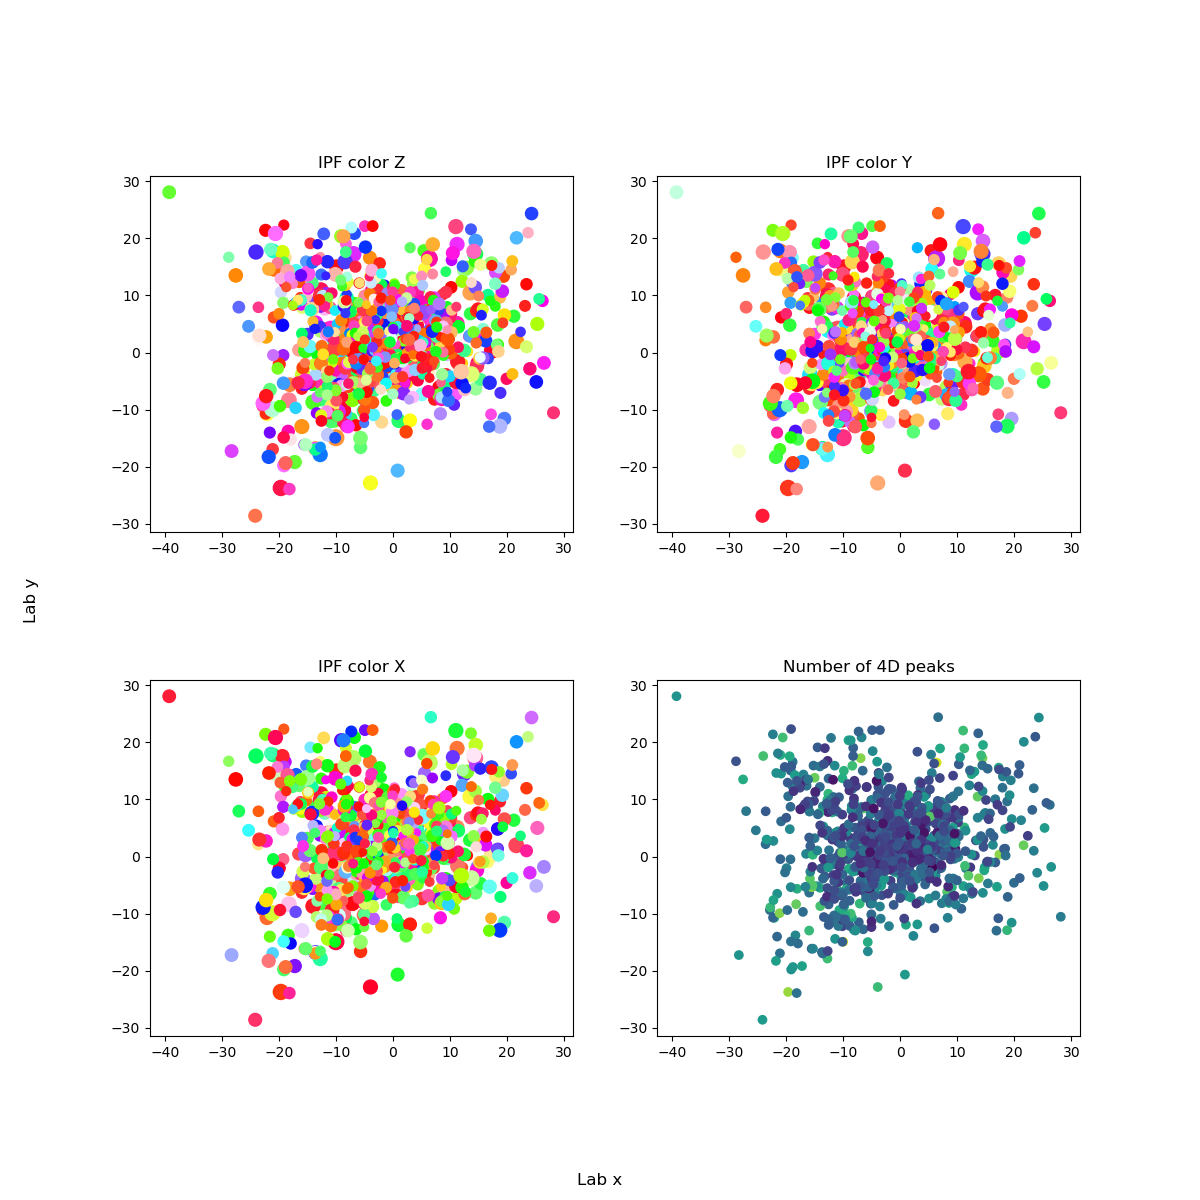

In [21]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12))
a = ax.ravel()
x = [g.dx for g in grains]
y = [g.dy for g in grains]
s = [g.peaks_4d_selected.sum()/10 for g in grains]
a[0].scatter(x, y, s=s, c=[g.rgb_z for g in grains])
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(x, y, s=s, c=[g.rgb_y for g in grains])
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(x, y, s=s, c=[g.rgb_x for g in grains])
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(x, y, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')

fig.supxlabel("Lab x")
fig.supylabel("Lab y")

plt.show()

In [22]:
# populate translations of grains
for g in grains:
    g.translation = np.array([g.dx, g.dy, 0])

In [23]:
# Big scary block
# Must understand what this does!

# Ensure cf is sorted by spot3d_id
# NOTE: spot3d_id should be spot4d_id, because we have merged into 4D?
assert (np.argsort(cf_strong.spot3d_id) == np.arange(cf_strong.nrows)).all()

# load the 2d peak labelling output
pks = ImageD11.sinograms.properties.pks_table.load(ds.pksfile)

# Grab the 2d peak centroids
p2d = pks.pk2d(ds.omega, ds.dty)

# NOTE: These are not spatially corrected?!

numba_order, numba_histo = utils.counting_sort(p2d['spot3d_id'])

grain_2d_id = utils.palloc(p2d['spot3d_id'].shape, np.dtype(int))

cleanid = cf_strong.grain_id.copy()

utils.find_grain_id(cf_strong.spot3d_id, cleanid, p2d['spot3d_id'], grain_2d_id, numba_order)

gord, counts = utils.counting_sort(grain_2d_id)

inds = np.concatenate(((0,), np.cumsum(counts)))

# I think what we end up with is:
# inds
# this is an array which tells you which 2D spots each grain owns
# the 2D spots are sorted by spot ID
# inds tells you for each grain were you can find its associated 2D spots

Using 20 threads


In [24]:
# now our 2D peak assignments are known, let's populate our grain objects with our 2D peaks

for grain in tqdm(grains):
    i = grain.gid
    grain.peaks_2d = gord[inds[i+1] : inds[i+2]]
    # grain.mask_2d = np.isin(cf_2d.index, grain.peaks_2d)

  0%|          | 0/1025 [00:00<?, ?it/s]

In [25]:
def map_grain_from_peaks(g, flt, ds):
    """
    Computes sinogram
    flt is already the peaks for this grain
    Returns angles, sino
    """   
    NY = len(ds.ybincens)  # number of y translations
    iy = np.round((flt.dty - ds.ybincens[0]) / (ds.ybincens[1]-ds.ybincens[0])).astype(int)  # flt column for y translation index

    # The problem is to assign each spot to a place in the sinogram
    hklmin = g.hkl_2d_strong.min(axis=1)  # Get minimum integer hkl (e.g -10, -9, -10)
    dh = g.hkl_2d_strong - hklmin[:,np.newaxis]  # subtract minimum hkl from all integer hkls
    de = (g.etasigns_2d_strong.astype(int) + 1)//2  # something signs related
    #   4D array of h,k,l,+/-
    # pkmsk is whether a peak has been observed with this HKL or not
    pkmsk = np.zeros(list(dh.max(axis=1) + 1 )+[2,], int)  # make zeros-array the size of (max dh +1) and add another axis of length 2
    pkmsk[ dh[0], dh[1], dh[2], de ] = 1  # we found these HKLs for this grain
    #   sinogram row to hit
    pkrow = np.cumsum(pkmsk.ravel()).reshape(pkmsk.shape) - 1  #
    # counting where we hit an HKL position with a found peak
    # e.g (-10, -9, -10) didn't get hit, but the next one did, so increment

    npks = pkmsk.sum( )
    destRow = pkrow[ dh[0], dh[1], dh[2], de ] 
    sino = np.zeros( ( npks, NY ), 'f' )
    hits = np.zeros( ( npks, NY ), 'f' )
    angs = np.zeros( ( npks, NY ), 'f' )
    adr = destRow * NY + iy 
    # Just accumulate 
    sig = flt.sum_intensity
    ImageD11.cImageD11.put_incr64( sino, adr, sig )
    ImageD11.cImageD11.put_incr64( hits, adr, np.ones(len(de),dtype='f'))
    ImageD11.cImageD11.put_incr64( angs, adr, flt.omega)
    
    sinoangles = angs.sum( axis = 1) / hits.sum( axis = 1 )
    # Normalise:
    sino = (sino.T/sino.max( axis=1 )).T
    # Sort (cosmetic):
    order = np.lexsort((np.arange(npks), sinoangles))
    sinoangles = sinoangles[order]
    ssino = sino[order].T
    return sinoangles, ssino, hits[order].T

def do_sinos(g, hkltol=0.25):
    flt = utils.tocolf({p:p2d[p][g.peaks_2d] for p in p2d}, par_path, dxfile=e2dx_path, dyfile=e2dy_path)  # convert it to a columnfile and spatially correct
    
    hkl_real = np.dot(g.ubi, (flt.gx, flt.gy, flt.gz))  # calculate hkl of all assigned peaks
    hkl_int = np.round(hkl_real).astype(int) # round to nearest integer
    dh = ((hkl_real - hkl_int)**2).sum(axis = 0)  # calculate square of difference

    # g.dherrall = dh.mean()  # mean hkl error across all assigned peaks
    # g.npksall = flt.nrows  # total number of assigned peaks
    flt.filter(dh < hkltol*hkltol)  # filter all assigned peaks to be less than hkltol squared
    hkl_real = np.dot(g.ubi, (flt.gx, flt.gy, flt.gz))  # recalculate error after filtration
    hkl_int = np.round(hkl_real).astype(int)
    dh = ((hkl_real - hkl_int)**2).sum(axis = 0)
    # g.dherr = dh.mean()  # dherr is mean hkl error across assigned peaks after hkltol filtering
    # g.npks = flt.nrows  # total number of assigned peaks after hkltol filtering
    g.etasigns_2d_strong = np.sign(flt.eta)
    g.hkl_2d_strong = hkl_int  # integer hkl of assigned peaks after hkltol filtering
    g.sinoangles, g.ssino, g.hits = map_grain_from_peaks(g, flt, ds)
    return i,g

In [26]:
# Determine sinograms of all grains

nthreads = len(os.sched_getaffinity(os.getpid()))

with concurrent.futures.ThreadPoolExecutor(max_workers= max(1,nthreads-1)) as pool:
    for i in tqdm(pool.map(do_sinos, grains), total=len(grains)):
        pass

  0%|          | 0/1025 [00:00<?, ?it/s]

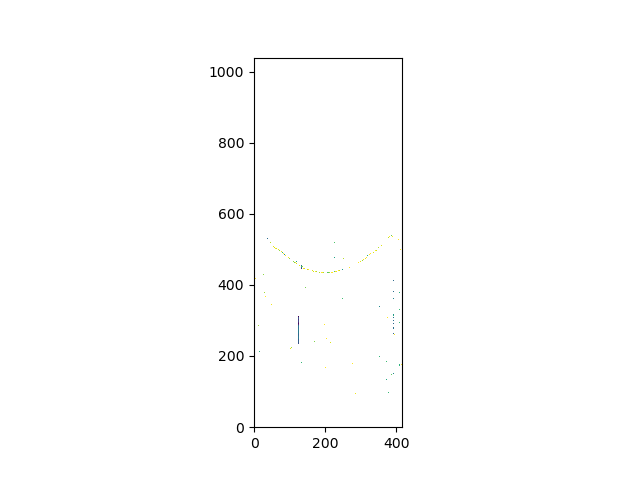

In [27]:
# Show sinogram of single grain

g = grains[0]

fig, ax = plt.subplots()

ax.imshow((g.ssino/g.ssino.mean(axis=0)), norm=matplotlib.colors.LogNorm(), interpolation='nearest', origin="lower")

plt.show()

In [28]:
def run_iradon_id11(grain, pad=20, y0=c0/2, workers=1, sample_mask=whole_sample_mask, apply_halfmask=is_half_scan, mask_central_zingers=False):
    outsize = grain.ssino.shape[0] + pad
    
    if apply_halfmask:
        halfmask = np.zeros_like(grain.ssino)

        halfmask[:len(halfmask)//2-1, :] = 1
        halfmask[len(halfmask)//2-1, :] = 0.5
        
        ssino_to_recon = grain.ssino * halfmask
    else:
        ssino_to_recon = grain.ssino
        
    # pad the sample mask
    # sample_mask_padded = np.pad(sample_mask, pad//2)

    
    # Perform iradon transform of grain sinogram, store result (reconstructed grain shape) in g.recon
    grain.recon = ImageD11.sinograms.roi_iradon.iradon(ssino_to_recon, 
                                                       theta=grain.sinoangles, 
                                                       mask=sample_mask,
                                                       output_size=outsize,
                                                       projection_shifts=np.full(grain.ssino.shape, -y0),
                                                       filter_name='hamming',
                                                       interpolation='linear',
                                                       workers=workers)
    
    if mask_central_zingers:
        grs = grain.recon.shape[0]
        xpr, ypr = -grs//2 + np.mgrid[:grs, :grs]
        inner_mask_radius = 25
        outer_mask_radius = inner_mask_radius + 2

        inner_circle_mask = (xpr ** 2 + ypr ** 2) < inner_mask_radius ** 2
        outer_circle_mask = (xpr ** 2 + ypr ** 2) < outer_mask_radius ** 2

        mask_ring = inner_circle_mask & outer_circle_mask
        # we now have a mask to apply
        fill_value = np.median(grain.recon[mask_ring])
        grain.recon[inner_circle_mask] = fill_value
    
    return grain

In [ ]:
# you can pick a grain and investigate the effects of changing y0 that gets passed to iradon
# it' best to pick the grain AFTER reconstructing all grains, so you can pick a grain of interest

g = grains[1066]
    
vals = np.linspace(-2.0, -1.0, 9)

grid_size = np.ceil(np.sqrt(len(vals))).astype(int)
nrows = (len(vals)+grid_size-1)//grid_size

fig, axs = plt.subplots(grid_size, nrows, sharex=True, sharey=True)

for inc, val in enumerate(tqdm.tqdm(vals)):
    run_iradon_id11(g, y0=val)
    # crop = g.recon[200:240, 230:290]
    crop = g.recon
    
    axs.ravel()[inc].imshow(crop, origin="lower")
    axs.ravel()[inc].set_title(val)
    
plt.show()

In [29]:
# you can overwrite y0 and pad here

y0 = -1.25
pad = 20

In [30]:
nthreads = len(os.sched_getaffinity(os.getpid()))

with concurrent.futures.ThreadPoolExecutor( max_workers= max(1,nthreads-1) ) as pool:
    for i in tqdm(pool.map(run_iradon_id11, grains, [pad]*len(grains), [y0]*len(grains)), total=len(grains)):
        pass

  0%|          | 0/1025 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=0, description='Grain:', max=1024), Output()), _dom_classes=('widget-int…

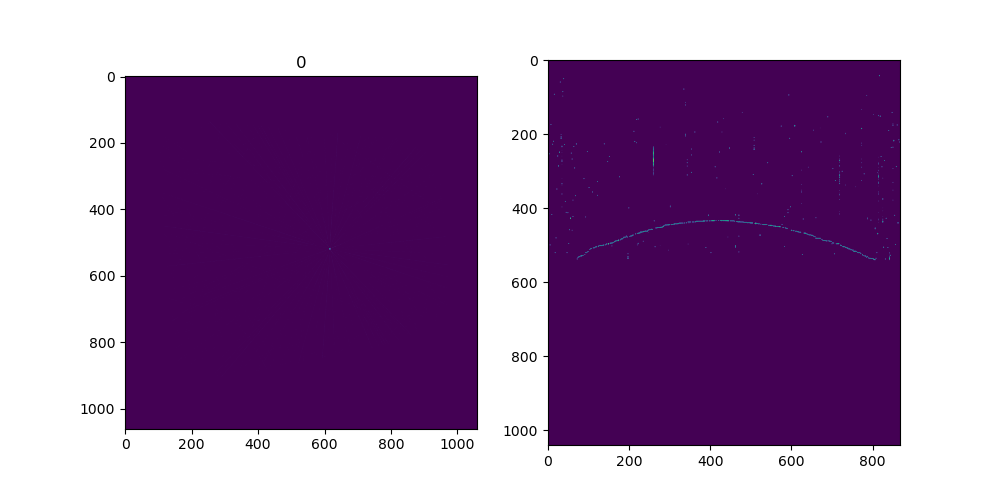

In [31]:
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib ipympl

fig, a = plt.subplots(1,2,figsize=(10,5))
rec = a[0].imshow(grains[8].recon, vmin=0)
sin = a[1].imshow(grains[8].ssino, aspect='auto')

# Function to update the displayed image based on the selected frame
def update_frame(i):
    rec.set_array(grains[i].recon)
    sin.set_array(grains[i].ssino)
    a[0].set(title=str(i))
    fig.canvas.draw()

# Create a slider widget to select the frame number
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)

interact(update_frame, i=frame_slider)

plt.show()

In [31]:
from skimage.feature import blob_log

def find_cens_from_recon(grain):
    grain.bad_recon = False
    blobs = blob_log(grain.recon, min_sigma=1, max_sigma=10, num_sigma=10, threshold=.01)
    blobs_sorted = sorted(blobs, key=lambda x: x[2], reverse=True)
    try:
        largest_blob = blobs_sorted[0]
        grain.x_blob = largest_blob[1]
        grain.y_blob = largest_blob[0]
    except IndexError:
        # didn't find any blobs
        # for small grains like these, if we didn't find a blob, normally indicates recon is bad
        # we will exclude it from maps and export
        grain.bad_recon = True

with concurrent.futures.ThreadPoolExecutor(max_workers= max(1, nthreads-1)) as pool:
    for i in tqdm(pool.map(find_cens_from_recon, grains), total=len(grains)):
        pass

  0%|          | 0/1025 [00:00<?, ?it/s]

In [32]:
# remove bad recon grains from future analysis
print(f"{len(grains)} grains before filtration")
grains = [grain for grain in grains if not grain.bad_recon]
print(f"{len(grains)} grains after filtration")

1025 grains before filtration
999 grains after filtration


In [33]:
for g in grains:
    g.translation = np.array([g.x_blob, g.y_blob, 0])

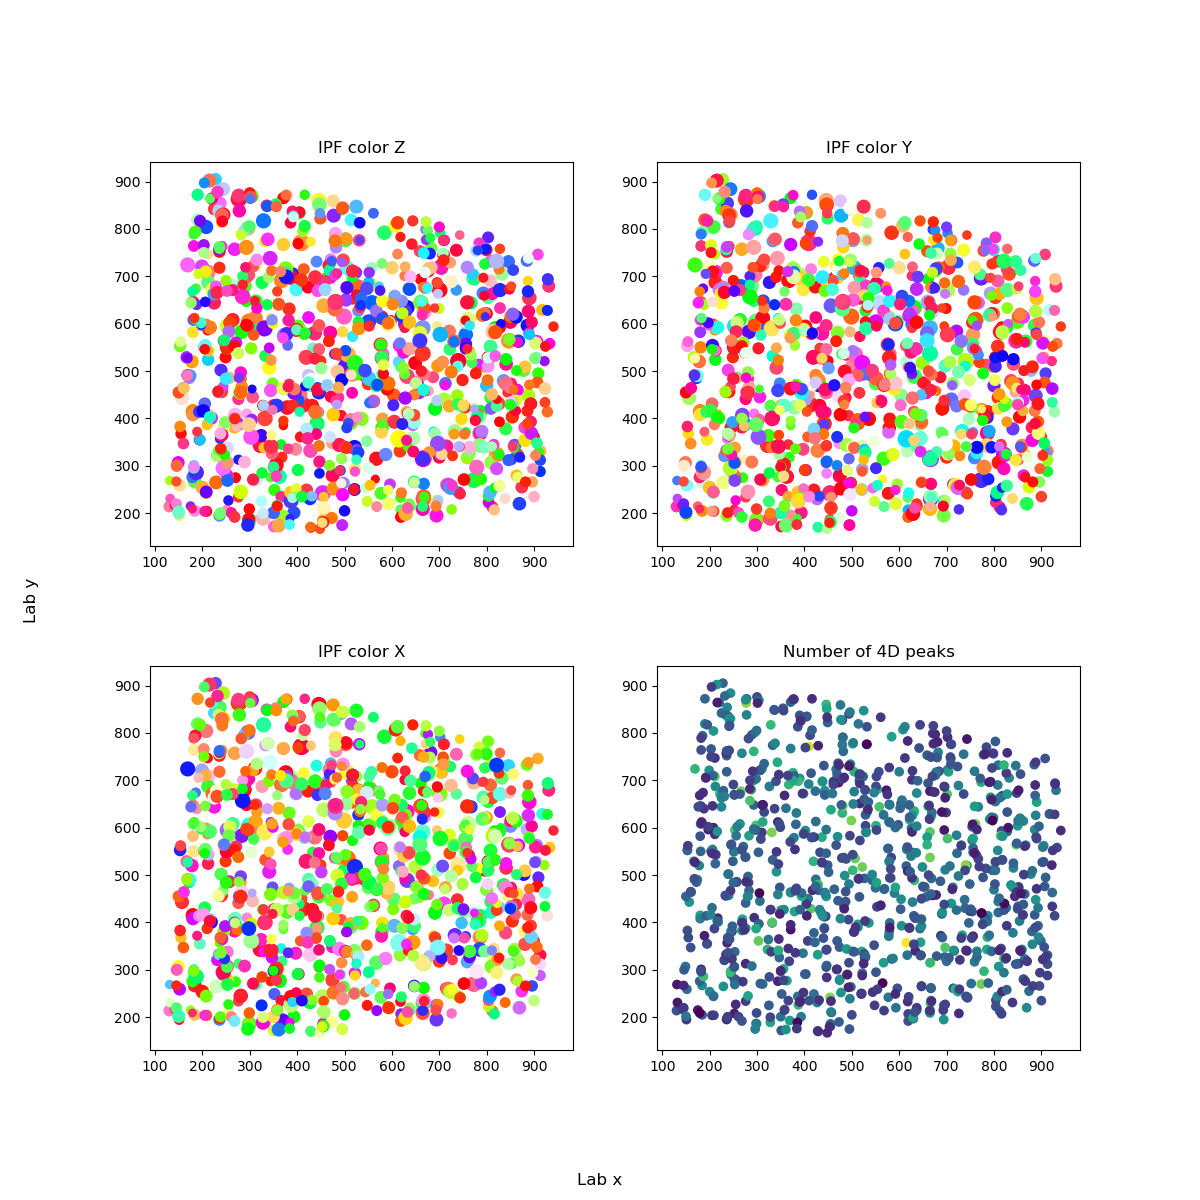

In [34]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12))
a = ax.ravel()
x = [g.x_blob for g in grains]
y = [g.y_blob for g in grains]
s = [g.peaks_4d_selected.sum()/10 for g in grains]
a[0].scatter(x, y, s=s, c=[g.rgb_z for g in grains])
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(x, y, s=s, c=[g.rgb_y for g in grains])
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(x, y, s=s, c=[g.rgb_x for g in grains])
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(x, y, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')

fig.supxlabel("Lab x")
fig.supylabel("Lab y")

plt.show()

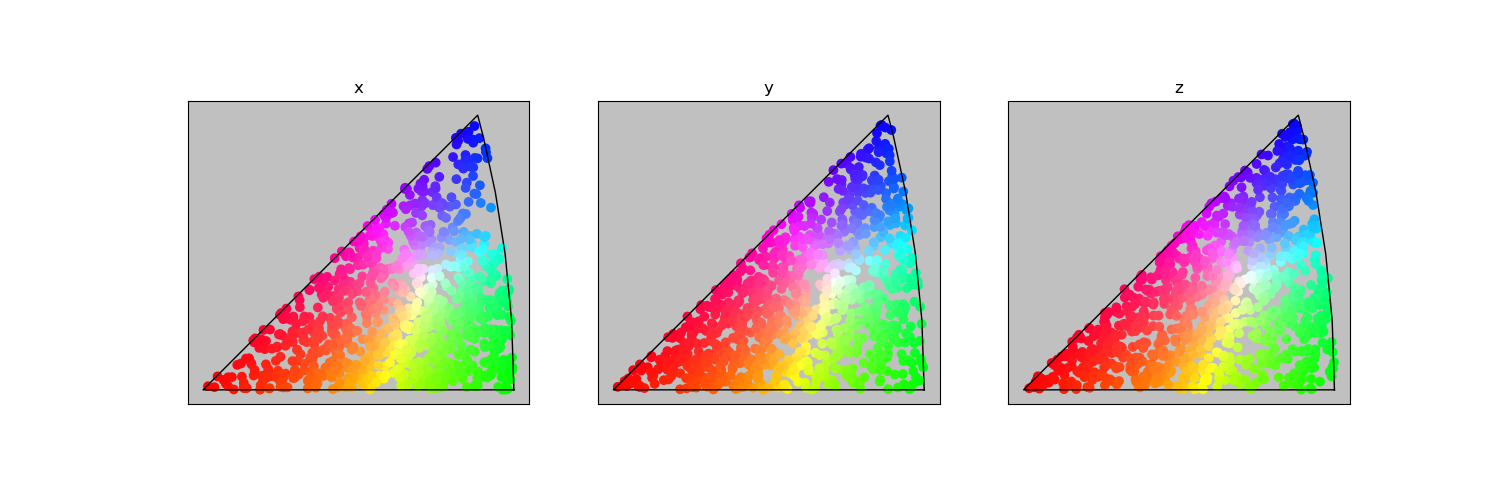

In [35]:
f,a = plt.subplots( 1,3, figsize=(15,5) )
ty, tx = utils.triangle().T
for i,title in enumerate( 'xyz' ):
    ax = np.zeros(3)
    ax[i] = 1.
    hkl = [utils.crystal_direction_cubic( g.ubi, ax ) for g in grains]
    xy = np.array([utils.hkl_to_pf_cubic(h) for h in hkl ])
    rgb = np.array([utils.hkl_to_color_cubic(h) for h in hkl ])
    for j in range(len(grains)):
        grains[j].rgb = rgb[j]
    a[i].scatter( xy[:,1], xy[:,0], c = rgb )   # Note the "x" axis of the plot is the 'k' direction and 'y' is h (smaller)
    a[i].set(title=title, aspect='equal', facecolor='silver', xticks=[], yticks=[])
    a[i].plot( tx, ty, 'k-', lw = 1 )

In [36]:
grain_labels_array = np.zeros_like(grains[0].recon) - 1
red = np.zeros_like(grains[0].recon)
grn = np.zeros_like(grains[0].recon)
blu = np.zeros_like(grains[0].recon)

raw_intensity_array = np.zeros_like(grains[0].recon)

cutoff_level = 0.5

raw_intensity_array.fill(cutoff_level)

# ignore the centre when determining r.max()???

def norm(r):
    m = r > r.max()*0.2
    return (r/r[m].mean()).clip(0,1)

for g in tqdm(grains):
    i = g.gid
    
    g_raw_intensity = norm(g.recon)
    
    g_raw_intensity_mask = g_raw_intensity > raw_intensity_array
    
    g_raw_intenstiy_map = g_raw_intensity[g_raw_intensity_mask]
    
    raw_intensity_array[g_raw_intensity_mask] = g_raw_intenstiy_map
    
    red[g_raw_intensity_mask] = g_raw_intenstiy_map*g.rgb_z[0]
    grn[g_raw_intensity_mask] = g_raw_intenstiy_map*g.rgb_z[1]
    blu[g_raw_intensity_mask] = g_raw_intenstiy_map*g.rgb_z[2]
    
    grain_labels_array[g_raw_intensity_mask] = i
    
raw_intensity_array[raw_intensity_array == cutoff_level] = 0

  0%|          | 0/999 [00:00<?, ?it/s]

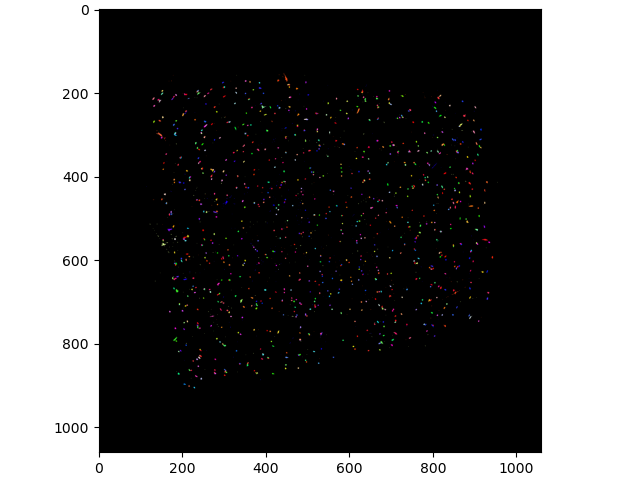

In [37]:
# plot initial output

image_to_show = np.transpose((red, grn, blu), axes=(1, 2, 0))
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image_to_show)  # originally 1,2,0
plt.show()

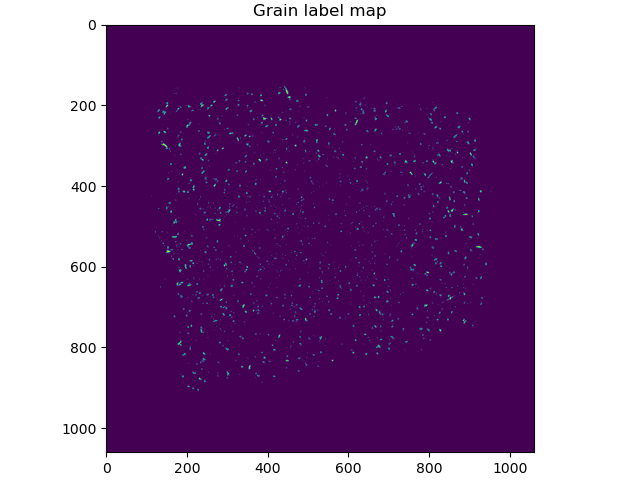

In [38]:
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(grain_labels_array)  # originally 1,2,0
ax.set_title("Grain label map")
plt.show()

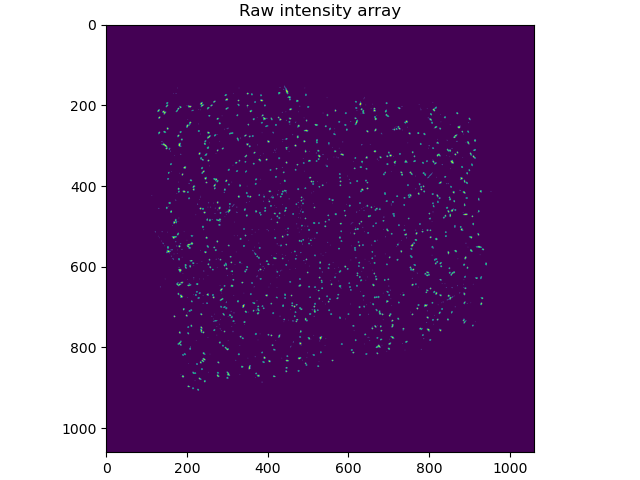

In [39]:
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(raw_intensity_array)  # originally 1,2,0
ax.set_title("Raw intensity array")
plt.show()

In [44]:
# write grains to disk

cmp = {'compression':'gzip',
       'compression_opts': 2,
       'shuffle' : True }

def save_array(grp, name, ary):
    hds = grp.require_dataset(name, 
                              shape=ary.shape,
                              dtype=ary.dtype,
                              **cmp)
    hds[:] = ary
    return hds

def save_grains(grains, ds):
    
    # delete existing file, because our grain numbers have changed
    if os.path.exists(ds.grainsfile_carbides):
        os.remove(ds.grainsfile_carbides)
    
    with h5py.File(ds.grainsfile_carbides, 'w-') as hout:  # fail if exists
        try:
            grp = hout.create_group('peak_assignments')
        except ValueError:
            grp = hout['peak_assignments']

        ds_gord = save_array( grp, 'gord', gord )
        ds_gord.attrs['description'] = 'Grain ordering: g[i].pks = gord[ inds[i] : inds[i+1] ]'
        ds_inds = save_array( grp, 'inds', inds )
        ds_inds.attrs['description'] = 'Grain indices: g[i].pks = gord[ inds[i] : inds[i+1] ]'
        
        try:
            grp = hout.create_group('slice_recon')
        except ValueError:
            grp = hout['slice_recon']
        save_array(grp, 'intensity', raw_intensity_array).attrs['description'] = 'Raw intensity array for all grains'
        save_array(grp, 'labels', grain_labels_array).attrs['description'] = 'Grain labels array for all grains'
        
        grains_group = hout.create_group('grains')
        for g in tqdm(grains):
            gg = grains_group.create_group(str(g.gid))
            # save stuff for sinograms
            
            gg.attrs.update({'ubi':g.ubi})
            
            save_array(gg, 'peaks_4d_indexing', g.peaks_4d).attrs['description'] = "Strong 4D peaks that were assigned to this grain during indexing"
            
            save_array(gg, 'ssino', g.ssino).attrs['description'] = 'Sinogram of peak intensities sorted by omega'
            save_array(gg, 'sinoangles', g.sinoangles).attrs['description'] = 'Projection angles for sinogram'
            save_array(gg, 'og_recon', g.recon).attrs['description'] = 'Original ID11 iRadon reconstruction'
            save_array(gg, 'recon', g.recon).attrs['description'] = 'Final reconstruction'
            save_array(gg, 'circle_mask', whole_sample_mask).attrs['description'] = 'Reconstruction mask to use for MLEM'
            
            # might as well save peaks stuff while we're here
            save_array(gg, 'translation', g.translation).attrs['description'] = 'Grain translation in lab frame'
            save_array(gg, 'peaks_2d_sinograms', g.peaks_2d).attrs['description'] = "2D peaks from strong 4D peaks that were assigned to this grain for sinograms"
            save_array(gg, 'peaks_4d_sinograms', g.peaks_4d).attrs['description'] = "Strong 4D peaks that were assigned to this grain for sinograms"

            gg.attrs['cen'] = g.cen

In [45]:
save_grains(grains, ds)

  0%|          | 0/999 [00:00<?, ?it/s]